# Visualizing calibration methods on simulated data

In [1]:
import os
import sys
import time
import random
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.stats.kde import gaussian_kde

from utils.ops import onehot_encode, project_sequence_onsimplex, project_sequence, optim_temperature
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, plot_cal_regions_ternary, plot_cal_regions_ternary_v2
from calibrators import TempScalingCalibrator, MLRCalibrator, PAVCalibrator

In [2]:
%matplotlib inline

Helper function to evaluate and visualize calibrators for different data sets:

In [3]:
def evaluate_calibrators(logits, target):
    ### Fit calibrators
    
    # Uncalibrated
    probs = softmax(logits, axis=1)
    nll = neg_log_likelihood(probs, target)
    ece = expected_calibration_error(probs, target)
    
    # Temp-Scaling
    temp_cal = TempScalingCalibrator(logits, target)
    temp_probs = temp_cal(logits)
    
    temp_nll = neg_log_likelihood(temp_probs, target)
    temp_ece = expected_calibration_error(temp_probs, target)
    
    # MLR
    mlr_cal = MLRCalibrator(logits, target)
    mlr_probs = mlr_cal(logits)
    
    mlr_nll = neg_log_likelihood(mlr_probs, target)
    mlr_ece = expected_calibration_error(mlr_probs, target)
    
    # PAV
    pav_cal = PAVCalibrator(logits, target)
    pav_probs = pav_cal(logits)
    
    pav_nll = neg_log_likelihood(pav_probs, target)
    pav_ece = expected_calibration_error(pav_probs, target)
    
    
    ### Create plot
    
    fig, ax_arr = plt.subplots(2, 4, figsize=(18, 10), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
    
    ax_arr[0, 0] = plot_pdf_simplex(probs, ax=ax_arr[0, 0], title='Uncalibrated PDF.\nNLL: {:.3f}'.format(nll))
    ax_arr[0, 1] = plot_pdf_simplex(temp_probs, ax=ax_arr[0, 1], title='Temp-Scaling PDF.\nNLL: {:.3f}'.format(temp_nll))
    ax_arr[0, 2] = plot_pdf_simplex(mlr_probs, ax=ax_arr[0, 2], title='MLR PDF.\nNLL: {:.3f}'.format(mlr_nll))
    ax_arr[0, 3] = plot_pdf_simplex(pav_probs, ax=ax_arr[0, 3], title='PAV PDF.\nNLL: {:.3f}'.format(pav_nll))
    
    ax_arr[1, 0] = plot_pdf_simplex(probs, target=target, ax=ax_arr[1, 0], title='Uncalibrated PDF of each class.\nECE(%): {:.2f}'.format(ece*100))
    ax_arr[1, 1] = plot_cal_regions_ternary(temp_cal, ax=ax_arr[1, 1], title='Temp-Scaling decision regions.\nECE(%): {:.2f}'.format(temp_ece*100))
    ax_arr[1, 2] = plot_cal_regions_ternary(mlr_cal, ax=ax_arr[1, 2], title='MLR decision regions.\nECE(%): {:.2f}'.format(mlr_ece*100))
    ax_arr[1, 3] = plot_cal_regions_ternary(pav_cal, ax=ax_arr[1, 3], title='PAV decision regions.\nECE(%): {:.2f}'.format(pav_ece*100))
    
    plt.show();

## Simulating data

True distribution:

In [4]:
n_samples = 500

target = np.array(random.choices(range(3), k=n_samples))
one_hot = onehot_encode(target)

### Accurate classifier:

In [5]:
acc_logits = one_hot+np.random.randn(n_samples, 3)*0.5

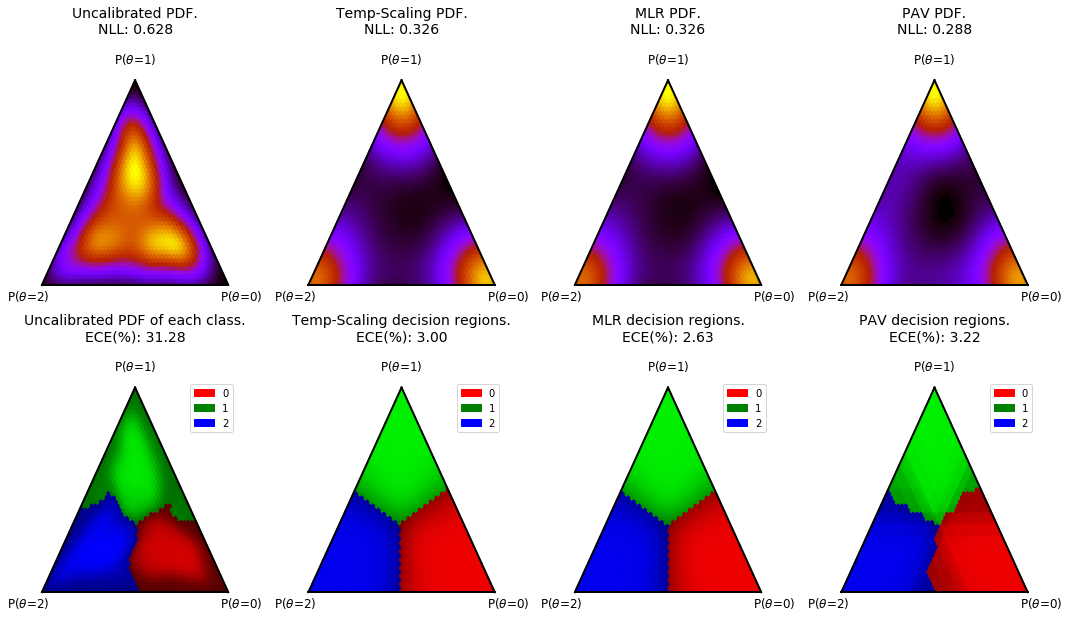

In [6]:
evaluate_calibrators(acc_logits, target)

All achieve same performance.

### Biased classifier:

Pull probabilities towards a subset of one or more classes.

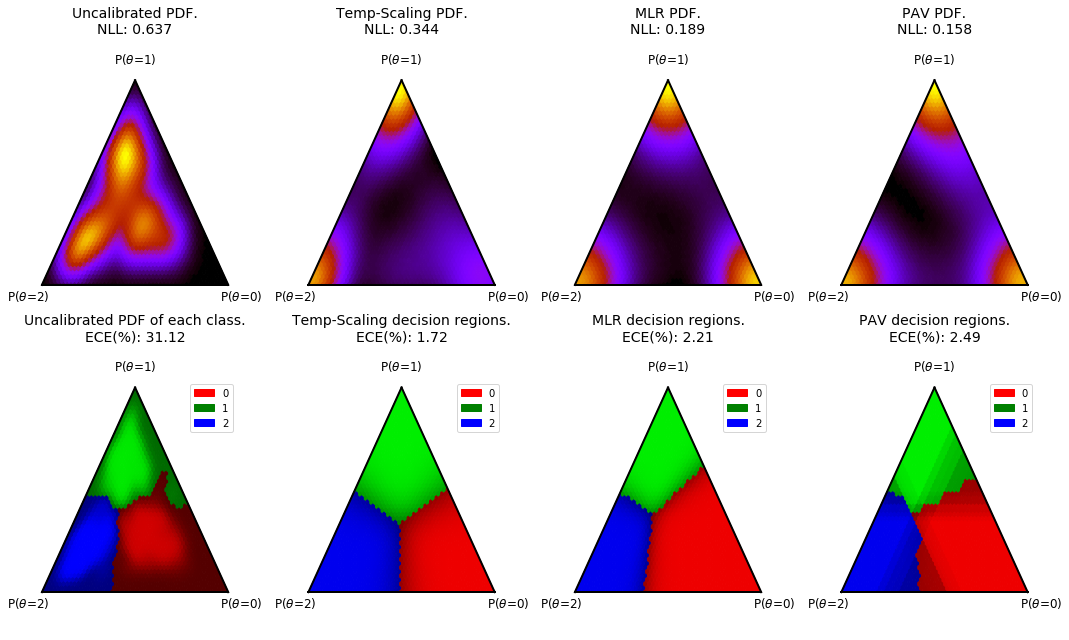

In [7]:
offset = np.zeros((n_samples, 3))
offset[:, 1:] = 0.5

shft_logits = one_hot + np.random.randn(n_samples, 3)*0.4 + offset

evaluate_calibrators(shft_logits, target)

PAV and MLR are capable of recovering the bias of the classifier.

### Biased and twistted classifier:

Classifier is not only biased towards a subset ot classes, but also probabilities are twistted on the 2-simplex.

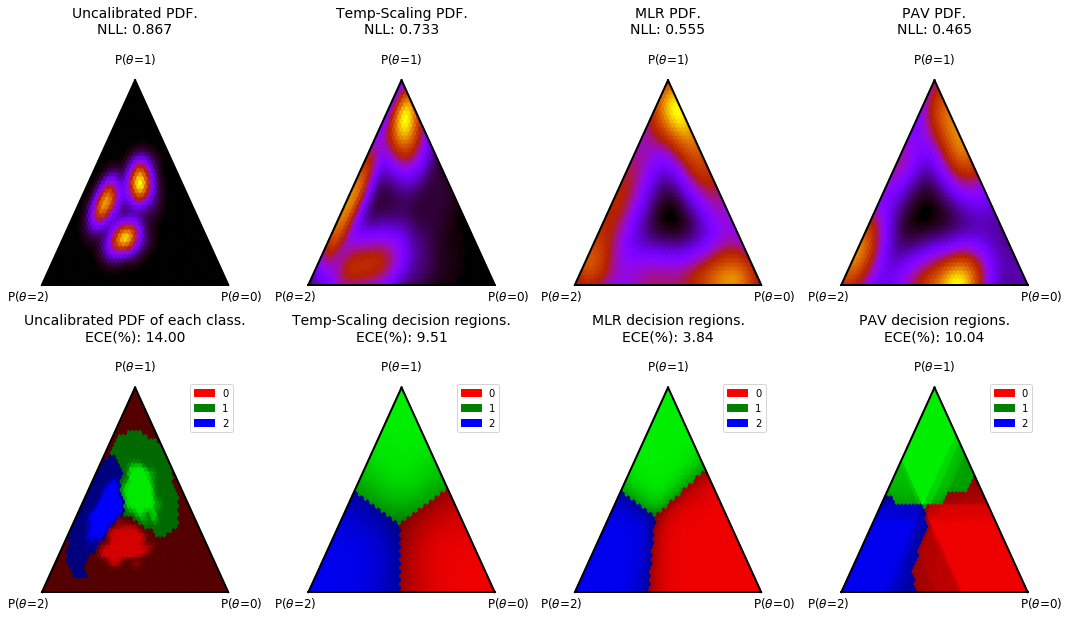

In [8]:
offset = np.zeros((n_samples, 3))
offset[:, 1:] = 0.4

twisting = np.zeros((n_samples, 3))
twisting[np.arange(n_samples), target-1] = 0.8 + np.random.randn(n_samples)*0.1

snt_logits = 0.8 * (one_hot + twisting + np.random.randn(n_samples, 3)*0.2) + offset

evaluate_calibrators(snt_logits, target)

### Analysis:

Although the 3 methods improve calibration, both in terms of ECE and NLL, none of them is able to recover from twistted probabilities, even when they are highly separable. Moreover, temp-scaling, cannot even deal with a biased classifier, which is a very common case when base rates, or priors, differ from train set to test set.

The three methods result in linear(-ish in the case of PAV) decision boundaries, these may not be expressive enough to solve calibration with high dimensional data, multiclass.